- In this notebook, every model in part 2 Classical Classifier has two cells. The first cell runs GridSearchCV to find the best score for a given model. GridSearchCV trains and evaluates only on the X_train and y_train using cross validation. The second cell uses the optimized parameters found for the model to get the result on the X_test and y_test. So <b>the result needs to get from this second cell, not the first.</b>
- For timing, use only the time interval of the second cell. Timing in the first cell is only for reference how long the GridSearch process takes. Because absolute timing is different between systems, we should only use relative timing.
- The results may still be improved because not all parameters and not all parameter ranges are included in GridSeachCV. <p>
- the global parameter n_cpus indicates how many CPU threads we want GridSearchCV to run. -1 means all the possible CPU threads. Note: this may slow down your system a lot. For example, my system has 8 cores (16 threads) so it is set to 14 so that the system still has one core (two threads) to run other jobs.


In [30]:
%matplotlib notebook

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score,precision_score,recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

import datetime
import matplotlib.pyplot as plt


In [2]:
# global defintions for grid search
scoring_criteria = 'precision'
n_cpus = 14

## 1. Data Processing

In [3]:
# for determination results
np.random.seed(0)
random_state = 0 # this variable is used for sklearn classifiers

# load dataframe
train = pd.read_csv('weatherAUS.csv')
train=train.sort_values(by='Date')
train=train.set_index('Date')

#remove the entries without label
train = train[~train['RainTomorrow'].isna()]

#NA
train =train.dropna()

#convert Location, WindGustDir,WindDir9am to categorical features
le =LabelEncoder()
le.fit(train['Location'])
train['Location']=le.transform(train['Location'])
le.fit(train['WindGustDir'])
train['WindGustDir'] = le.transform(train['WindGustDir'])
le.fit(train['WindDir9am']) 
train['WindDir9am'] = le.transform(train['WindDir9am'])
le.fit(train['WindDir3pm']) 
train['WindDir3pm'] = le.transform(train['WindDir3pm'])

#convert the text labels to categorical
train['RainToday']=train['RainToday'].map(dict(Yes=1, No=0))
train['RainTomorrow']=train['RainTomorrow'].map(dict(Yes=1, No=0))


In [4]:
# have a quick look
train.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2007-11-01,3,8.0,24.3,0.0,3.4,6.3,7,30.0,12,7,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,0,1
2007-11-02,3,14.0,26.9,3.6,4.4,9.7,1,39.0,0,13,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,1,1
2007-11-03,3,13.7,23.4,3.6,5.8,3.3,7,85.0,3,5,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,1,1
2007-11-04,3,13.3,15.5,39.8,7.2,9.1,7,54.0,14,13,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,1,1
2007-11-05,3,7.6,16.1,2.8,5.6,10.6,10,50.0,10,2,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,1,0


In [5]:
# distribution of output labels
train.groupby('RainTomorrow')['RainTomorrow'].agg('count')

RainTomorrow
0    43993
1    12427
Name: RainTomorrow, dtype: int64

In [6]:
# correlation
train.corr()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Location,1.000000,-0.155954,-0.147500,-0.043314,-0.011509,-0.033941,0.099918,0.085603,-0.033247,0.085732,...,0.107279,0.026147,0.088567,0.120987,0.018257,0.010527,-0.194449,-0.148955,-0.006037,-0.005100
MinTemp,-0.155954,1.000000,0.749687,0.110800,0.506764,0.076087,-0.190554,0.118054,-0.058310,-0.194123,...,-0.174991,0.070827,-0.475661,-0.495577,0.106177,0.042173,0.906295,0.727222,0.048953,0.087428
MaxTemp,-0.147500,0.749687,1.000000,-0.069981,0.650964,0.463913,-0.244508,0.035531,-0.246043,-0.200750,...,-0.495781,-0.448116,-0.350980,-0.451691,-0.263634,-0.257752,0.893387,0.984841,-0.221810,-0.147467
Rainfall,-0.043314,0.110800,-0.069981,1.000000,-0.077239,-0.246379,0.067350,0.106308,0.098980,0.059229,...,0.263625,0.277625,-0.180606,-0.137302,0.217169,0.191433,0.013713,-0.074627,0.550515,0.254342
Evaporation,-0.011509,0.506764,0.650964,-0.077239,1.000000,0.369250,-0.104656,0.209566,-0.130683,-0.072357,...,-0.554232,-0.422436,-0.297319,-0.325954,-0.199809,-0.202366,0.593122,0.630727,-0.218079,-0.130002
Sunshine,-0.033941,0.076087,0.463913,-0.246379,0.369250,1.000000,-0.087355,-0.052422,-0.108689,-0.050795,...,-0.500343,-0.629299,0.043330,-0.020632,-0.677939,-0.702022,0.289038,0.486129,-0.328904,-0.453407
WindGustDir,0.099918,-0.190554,-0.244508,0.067350,-0.104656,-0.087355,1.000000,0.119678,0.430859,0.619892,...,0.096059,0.053719,-0.118875,-0.022979,0.078431,0.079285,-0.233490,-0.258929,0.148775,0.061751
WindGustSpeed,0.085603,0.118054,0.035531,0.106308,0.209566,-0.052422,0.119678,1.000000,0.023396,0.113687,...,-0.193410,-0.042653,-0.430363,-0.383683,0.088129,0.131590,0.085520,-0.000382,0.146276,0.233158
WindDir9am,-0.033247,-0.058310,-0.246043,0.098980,-0.130683,-0.108689,0.430859,0.023396,1.000000,0.320818,...,0.165935,0.189645,-0.034289,0.060506,0.115243,0.069308,-0.152185,-0.252951,0.181461,0.035992
WindDir3pm,0.085732,-0.194123,-0.200750,0.059229,-0.072357,-0.050795,0.619892,0.113687,0.320818,1.000000,...,0.054109,-0.004667,-0.120668,-0.021374,0.049014,0.057746,-0.212512,-0.214044,0.128209,0.032203


<IPython.core.display.Javascript object>


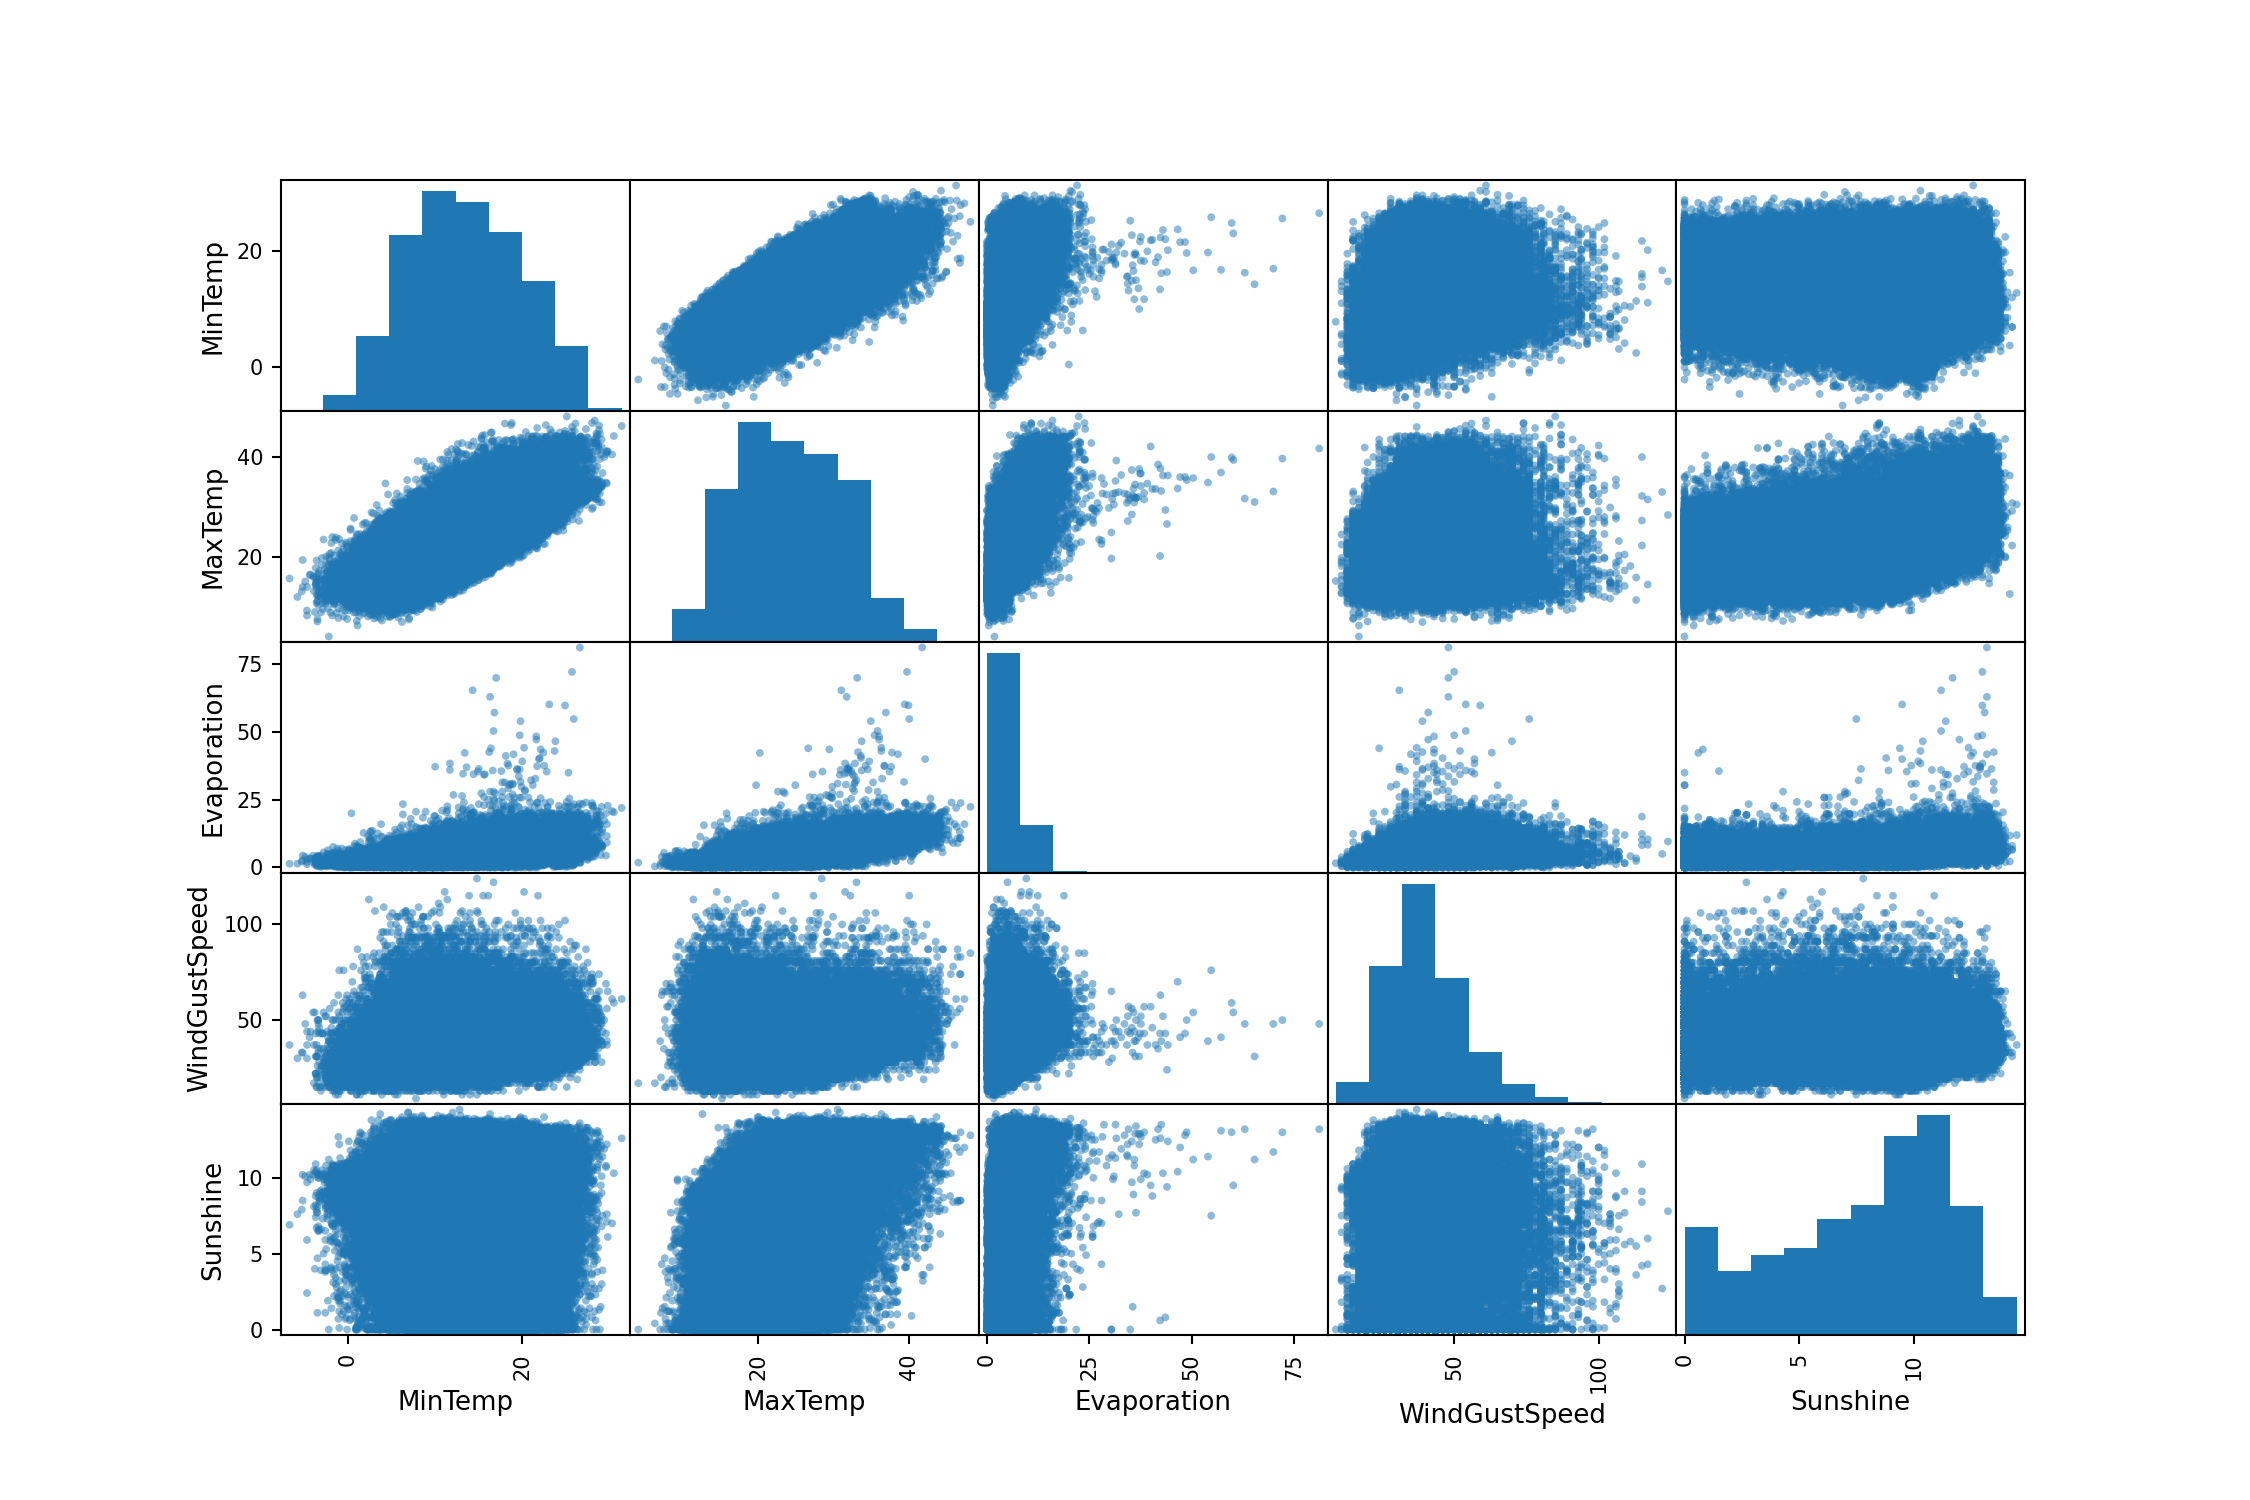

In [7]:
features=['MinTemp', 'MaxTemp', 'Evaporation', 'WindGustSpeed','Sunshine']
_=pd.plotting.scatter_matrix(train[features], figsize=(12,8))

In [8]:
X = train.drop('RainTomorrow',axis=1)
y = train['RainTomorrow']

In [9]:
X.shape

(56420, 21)

In [10]:
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
Date,,,,,,,,,,,,,,,,,,,,,
2007-11-01,3,8.0,24.3,0.0,3.4,6.3,7,30.0,12,7,...,20.0,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,0
2007-11-02,3,14.0,26.9,3.6,4.4,9.7,1,39.0,0,13,...,17.0,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,1
2007-11-03,3,13.7,23.4,3.6,5.8,3.3,7,85.0,3,5,...,6.0,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,1
2007-11-04,3,13.3,15.5,39.8,7.2,9.1,7,54.0,14,13,...,24.0,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,1
2007-11-05,3,7.6,16.1,2.8,5.6,10.6,10,50.0,10,2,...,28.0,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,1


In [11]:
y.head()

Date
2007-11-01    1
2007-11-02    1
2007-11-03    1
2007-11-04    1
2007-11-05    0
Name: RainTomorrow, dtype: int64

## 2. Classical Classifiers

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

### 2.1 Decision Tree

In [13]:
#search for the best parameters for DecisionTree
start = datetime.datetime.now()
clf = DecisionTreeClassifier(random_state=0)
max_features=np.arange(1,len(X_train.columns)+1)
max_depth = [4,5,6,7,8,9,10,None]
criterion= ['gini', 'entropy']
splitter=['best', 'random']
grid_clf = GridSearchCV(clf, param_grid={'max_features':max_features, 
                                         'max_depth': max_depth,
                                         'criterion': criterion,
                                         'splitter': splitter}, n_jobs = n_cpus, scoring = scoring_criteria, cv=5)
grid_clf.fit(X_train, y_train)
end = datetime.datetime.now()
print(f'Start: {start}, End: {end}, Interval: { end - start}')
print(f'Best parameters for Decision Tree: {grid_clf.best_params_}, best score: {grid_clf.best_score_}')
                        

Start: 2021-05-30 10:41:01.101430, End: 2021-05-30 10:41:48.675193, Interval: 0:00:47.573763
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 4, 'max_features': 8, 'splitter': 'random'}, best score: 0.8698940384305264


In [14]:
# use the params found from Grid Search
start = datetime.datetime.now()
clf = DecisionTreeClassifier(random_state=0, max_depth = grid_clf.best_params_['max_depth'], 
                             max_features = grid_clf.best_params_['max_features'],
                             criterion=grid_clf.best_params_['criterion'], 
                             splitter=grid_clf.best_params_['splitter'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf_precision = precision_score(y_test, y_pred)
end = datetime.datetime.now()
print(f'Start: {start}, End: {end}, Interval: { end - start}')
print(f'Decision Tree - Precision: {clf_precision}')


Start: 2021-05-30 10:41:48.679389, End: 2021-05-30 10:41:48.696547, Interval: 0:00:00.017158
Decision Tree - Precision: 0.9642857142857143


### 2.2 Random Forest

In [15]:
#search for the best parameters for RandomForest
start = datetime.datetime.now()
clf = RandomForestClassifier(random_state=0)
max_features=np.arange(1,len(X_train.columns)+1)
max_depth = [1,2,3,4,5,None]
grid_clf = GridSearchCV(clf, param_grid={'max_features':max_features, 
                                         'max_depth': max_depth}, n_jobs = n_cpus, scoring = scoring_criteria, cv=5)
grid_clf.fit(X_train, y_train)
end = datetime.datetime.now()
print(f'Best parameters for Random Forest: {grid_clf.best_params_}, best score: {grid_clf.best_score_}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')
                        

Best parameters for Random Forest: {'max_depth': 3, 'max_features': 1}, best score: 0.9545856365856367
Start: 2021-05-30 10:41:48.701161, End: 2021-05-30 10:46:01.856238, Interval: 0:04:13.155077


In [16]:
# Use the params found from Grid Search
start = datetime.datetime.now()
clf = RandomForestClassifier(random_state=0, max_depth = grid_clf.best_params_['max_depth'], 
                             max_features = grid_clf.best_params_['max_features'])
#clf = RandomForestClassifier(random_state=0 )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf_precision = precision_score(y_test, y_pred)
end = datetime.datetime.now()
print(f'Decision Tree - Precision: {clf_precision}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')


Decision Tree - Precision: 0.9897959183673469
Start: 2021-05-30 10:46:01.862651, End: 2021-05-30 10:46:02.599400, Interval: 0:00:00.736749


### 2.3 Gradient Boosting

In [17]:
#search for the best parameters for Gradient Boosting
start = datetime.datetime.now()
clf = GradientBoostingClassifier(random_state=0)
learning_rate = [0.001, 0.005, 0.01, 0.1, 0.2, 0.4, 1]
n_estimators = [100,200,300,400,500]
grid_clf = GridSearchCV(clf, param_grid={'learning_rate':learning_rate, 
                                         'n_estimators': n_estimators}, n_jobs = n_cpus, scoring = scoring_criteria, cv=5)
grid_clf.fit(X_train, y_train)
end = datetime.datetime.now()
print(f'Best parameters for Gradient Boosting: {grid_clf.best_params_}, best score: {grid_clf.best_score_}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')
                        

Best parameters for Gradient Boosting: {'learning_rate': 0.005, 'n_estimators': 200}, best score: 0.8532660867739406
Start: 2021-05-30 10:46:02.603336, End: 2021-05-30 10:51:40.768373, Interval: 0:05:38.165037


In [18]:
# Use the params found from Grid Search
start = datetime.datetime.now()
clf = GradientBoostingClassifier(random_state=0, learning_rate = grid_clf.best_params_['learning_rate'],
                                                 n_estimators = grid_clf.best_params_['n_estimators'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf_precision = precision_score(y_test, y_pred)
end = datetime.datetime.now()
print(f'Gradient Boosting - Precision: {clf_precision}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')


Gradient Boosting - Precision: 0.839142091152815
Start: 2021-05-30 10:51:40.772031, End: 2021-05-30 10:51:56.790803, Interval: 0:00:16.018772


### 2.4 Logistic Regression

In [19]:
#search for the best parameters for Logistic Regression
start = datetime.datetime.now()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = LogisticRegression(random_state=0)
penalty=['l2']
max_iter = [2000,4000]
C = [0.1, 0.5, 1, 5, 10]
#solver=['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
solver=['lbfgs',  'saga']
grid_clf = GridSearchCV(clf, param_grid={'penalty': penalty,
                                         'max_iter': max_iter,
                                         'solver': solver,
                                         'C': C}, n_jobs = n_cpus, scoring = scoring_criteria, cv=5)
grid_clf.fit(X_train, y_train)
end = datetime.datetime.now()
print(f'Logistic Regression: {grid_clf.best_params_}, best score: {grid_clf.best_score_}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')
                        

Logistic Regression: {'C': 0.5, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}, best score: 0.9794044665012407
Start: 2021-05-30 10:51:56.795415, End: 2021-05-30 10:52:00.042545, Interval: 0:00:03.247130


In [20]:
start = datetime.datetime.now()
clf=LogisticRegression(random_state=0, penalty=grid_clf.best_params_['penalty'], 
                       C= grid_clf.best_params_['C'], max_iter=grid_clf.best_params_['max_iter'],
                       solver=grid_clf.best_params_['solver'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf_precision= precision_score(y_test, y_pred)
end = datetime.datetime.now()
print(f'Logistic Regression - Precision: {clf_precision}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')


Logistic Regression - Precision: 0.9565217391304348
Start: 2021-05-30 10:52:00.047563, End: 2021-05-30 10:52:00.138577, Interval: 0:00:00.091014


### 2.5 SVC

In [21]:
#search for the best parameters for C-SVM
start = datetime.datetime.now()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = SVC(random_state=0)
max_iter = [15000,20000]
C = [0.1, 0.5, 1, 10, 100]  # reversely proportional to regularization
gamma = [0.0001,0.0005,0.001, 0.005, 0.01 ] # lower value -> farther traning example influcence
kernel = ['linear', 'rbf']
grid_clf = GridSearchCV(clf, param_grid={'max_iter': max_iter,
                                         'gamma': gamma,
                                         'kernel': kernel,
                                         'C': C}, n_jobs = n_cpus, scoring = scoring_criteria, cv=5)
grid_clf.fit(X_train, y_train)
end = datetime.datetime.now()
print(f'SVC: {grid_clf.best_params_}, best score: {grid_clf.best_score_}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')


#SVC: {'C': 1, 'gamma': 0.001, 'kernel': 'linear', 'max_iter': 15000}, best score: 0.9367927547069798                        

SVC: {'C': 1, 'gamma': 0.0001, 'kernel': 'linear', 'max_iter': 15000}, best score: 0.9367927547069798
Start: 2021-05-30 10:52:00.144731, End: 2021-05-30 11:36:19.836085, Interval: 0:44:19.691354


In [22]:
start = datetime.datetime.now()
clf=SVC(random_state=0, C= grid_clf.best_params_['C'], gamma = grid_clf.best_params_['gamma'],
                        max_iter=grid_clf.best_params_['max_iter'], kernel = grid_clf.best_params_['kernel'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf_precision= precision_score(y_test, y_pred)
end = datetime.datetime.now()
print(f'SVC - Precision: {clf_precision}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')


SVC - Precision: 0.9379084967320261
Start: 2021-05-30 11:36:19.840432, End: 2021-05-30 11:36:41.076072, Interval: 0:00:21.235640


### 2.6 K-Neighbors

In [23]:
#search for the best parameters for K-nearest-neighbor
start = datetime.datetime.now()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = KNeighborsClassifier()
n_neighbors = [ 5, 11, 15, 20, 25]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']
p=[2,3]
grid_clf = GridSearchCV(clf, param_grid={'n_neighbors': n_neighbors,
                                         'algorithm': algorithm,
                                         'p':p,
                                         'weights': weights}, n_jobs = n_cpus, scoring = scoring_criteria, cv=5)
grid_clf.fit(X_train, y_train)
end = datetime.datetime.now()
print(f'K-Neighbors: {grid_clf.best_params_}, best score: {grid_clf.best_score_}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')
                        

K-Neighbors: {'algorithm': 'auto', 'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}, best score: 0.776050494177358
Start: 2021-05-30 11:36:41.085792, End: 2021-05-30 11:59:45.444347, Interval: 0:23:04.358555


In [24]:
start = datetime.datetime.now()
clf=KNeighborsClassifier( n_neighbors= grid_clf.best_params_['n_neighbors'], 
                         weights = grid_clf.best_params_['weights'], 
                         p = grid_clf.best_params_['p']
                        )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf_precision= precision_score(y_test, y_pred)
end = datetime.datetime.now()
print(f'K-Neighbors - Precision: {clf_precision}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')


K-Neighbors - Precision: 0.760601180891036
Start: 2021-05-30 11:59:45.451423, End: 2021-05-30 11:59:54.116451, Interval: 0:00:08.665028


In [38]:
#search for the best parameters for Bernoulli Naive Bayes
start = datetime.datetime.now()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = BernoulliNB()
alpha = [1e-10, 1e-9, 1e-8, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
grid_clf = GridSearchCV(clf, param_grid={'alpha': alpha}, n_jobs = n_cpus, scoring = scoring_criteria, cv=5)
grid_clf.fit(X_train, y_train)
end = datetime.datetime.now()
print(f'Bernoulli: {grid_clf.best_params_}, best score: {grid_clf.best_score_}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')
                        

Bernoulli: {'alpha': 1e-10}, best score: 0.47467335143112255
Start: 2021-05-30 13:24:36.726902, End: 2021-05-30 13:24:37.353841, Interval: 0:00:00.626939


In [35]:
start = datetime.datetime.now()
clf=BernoulliNB( alpha = grid_clf.best_params_['alpha'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf_precision= precision_score(y_test, y_pred)
end = datetime.datetime.now()
print(f'Bernoulli NB - Precision: {clf_precision}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')


Bernoulli NB - Precision: 0.4736015084852294
Start: 2021-05-30 13:23:52.648680, End: 2021-05-30 13:23:52.667480, Interval: 0:00:00.018800


In [25]:
end = datetime.datetime.now()
print(f'End time {end}')

End time 2021-05-30 11:59:54.119209


## 3. Neural Network Classifiers

### 3.1 MLP

In [28]:
#search for the best parameters for MLP Classifier
start = datetime.datetime.now()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
start = datetime.datetime.now()
clf = MLPClassifier(random_state = random_state, learning_rate_init = 0.00001)
hidden_layer_sizes = [(100, 50)]
batch_size = [128,256,512]
max_iter = [2000,5000,10000]
learning_rate = ['constant', 'invscaling', 'adaptive']
grid_clf = GridSearchCV(clf, param_grid={'hidden_layer_sizes':hidden_layer_sizes,
                                         'batch_size':batch_size, 
                                         'max_iter': max_iter,
                                         'learning_rate': learning_rate}, n_jobs = n_cpus, scoring = scoring_criteria, cv=5)
grid_clf.fit(X_train, y_train)
end = datetime.datetime.now()
print(f'MLP: {grid_clf.best_params_}, best score: {grid_clf.best_score_}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')
                        

MLP: {'batch_size': 256, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 2000}, best score: 0.7315240043792782
Start: 2021-05-30 12:03:36.229751, End: 2021-05-30 12:14:11.987913, Interval: 0:10:35.758162


In [27]:
start = datetime.datetime.now()
clf = MLPClassifier( hidden_layer_sizes= grid_clf.best_params_['hidden_layer_sizes'], 
           batch_size = grid_clf.best_params_['batch_size'],
           learning_rate = grid_clf.best_params_['learning_rate'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
fprs,tprs,_ = roc_curve(y_test,y_pred)
clf_auc = auc(fprs,tprs)
clf_precision= precision_score(y_test, y_pred)
end = datetime.datetime.now()
print(f'MLP - AUC: { clf_auc}, precision: {clf_precision}')
print(f'Start: {start}, End: {end}, Interval: { end - start}')


MLP - AUC: 0.7488513661202186, precision: 0.6886574074074074
Start: 2021-05-30 12:02:16.819337, End: 2021-05-30 12:02:40.055107, Interval: 0:00:23.235770


### 3.2 Deep-Learning models (see the notebook aus_rainfall_prediction_dl_v2)